In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

In [4]:
import matplotlib.pyplot as plt
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [6]:
# Set style for better visualizations
plt.style.use('classic')
sns.set_palette("husl")

# Load the processed data
df = pd.read_csv('../data/processed/processed_data.csv')
df['Shipment Date'] = pd.to_datetime(df['Shipment Date'])
df['Planned Delivery Date'] = pd.to_datetime(df['Planned Delivery Date'])
df['Actual Delivery Date'] = pd.to_datetime(df['Actual Delivery Date'])

In [16]:
# 1. Basic Statistics and Data Overview
def print_basic_stats():
    print("Dataset Overview:")
    print("-----------------")
    print(f"Total number of shipments: {len(df)}")
    print(f"Delayed shipments: {df['Delayed'].sum()} ({round(df['Delayed'].mean() * 100, 2)}%)")
    print("\nDelivery Time Statistics (in days):")
    print(df[['Actual_Delivery_Time', 'Planned_Delivery_Time']].describe().round(2))

In [17]:
# 2. Temporal Analysis
def plot_temporal_patterns():
    # Monthly trend of delays
    plt.figure(figsize=(15, 6))
    monthly_delays = df.groupby('Shipment_Month')['Delayed'].mean() * 100
    monthly_delays.plot(kind='line', marker='o')
    plt.title('Monthly Trend of Delays')
    plt.xlabel('Month')
    plt.ylabel('Delay Percentage')
    plt.grid(True)
    plt.show()
    
    # Day of week analysis
    plt.figure(figsize=(10, 6))
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow_delays = df.groupby('Shipment_Day_Of_Week')['Delayed'].mean() * 100
    dow_delays.index = day_names
    dow_delays.plot(kind='bar')
    plt.title('Delay Percentage by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Delay Percentage')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [18]:
# 3. Distance Analysis
def analyze_distance():
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Distance_Category', y='Distance (km)', hue='Delayed', data=df)
    plt.title('Distance Distribution by Category and Delay Status')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Distance vs Delay Probability
    distance_bins = pd.qcut(df['Distance (km)'], q=10)
    delay_prob = df.groupby(distance_bins)['Delayed'].mean() * 100
    plt.figure(figsize=(12, 6))
    delay_prob.plot(kind='bar')
    plt.title('Delay Probability by Distance Deciles')
    plt.xlabel('Distance Range')
    plt.ylabel('Delay Probability (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [19]:
# 4. Vehicle Type Analysis
def analyze_vehicle_types():
    # Delay rate by vehicle type
    plt.figure(figsize=(10, 6))
    vehicle_delays = df.groupby('Vehicle Type')['Delayed'].mean() * 100
    vehicle_delays.plot(kind='bar')
    plt.title('Delay Percentage by Vehicle Type')
    plt.xlabel('Vehicle Type')
    plt.ylabel('Delay Percentage')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Vehicle type distribution by distance
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Vehicle Type', y='Distance (km)', data=df)
    plt.title('Distance Distribution by Vehicle Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [20]:
# 5. Weather and Traffic Impact
def analyze_weather_traffic():
    # Create a cross-tab of weather and traffic conditions
    delay_matrix = pd.crosstab(df['Weather Conditions'], df['Traffic Conditions'], 
                              values=df['Delayed'], aggfunc='mean') * 100
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(delay_matrix, annot=True, fmt='.1f', cmap='YlOrRd')
    plt.title('Delay Percentage by Weather and Traffic Conditions')
    plt.tight_layout()
    plt.show()


In [21]:
 #6. Route Analysis
def analyze_routes():
    # Top 10 routes by delay frequency
    routes = df.groupby(['Origin', 'Destination'])['Delayed'].agg(['count', 'mean'])
    routes = routes[routes['count'] >= 10]  # Filter routes with at least 10 shipments
    routes['delay_percentage'] = routes['mean'] * 100
    routes = routes.sort_values('delay_percentage', ascending=False)
    
    plt.figure(figsize=(12, 6))
    top_10_routes = routes.head(10)
    plt.bar(range(len(top_10_routes)), top_10_routes['delay_percentage'])
    plt.xticks(range(len(top_10_routes)), 
               [f"{o}-{d}" for o, d in top_10_routes.index], 
               rotation=45)
    plt.title('Top 10 Routes by Delay Percentage')
    plt.ylabel('Delay Percentage')
    plt.tight_layout()
    plt.show()

In [22]:
# 7. Correlation Analysis
def plot_correlations():
    # Select numerical columns
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    corr_matrix = df[numerical_cols].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()


In [23]:
# 8. Feature Importance Analysis
def analyze_feature_importance():
    from sklearn.ensemble import RandomForestClassifier
    
    # Prepare features
    features = ['Distance (km)', 'Shipment_Month', 'Shipment_Day_Of_Week',
                'Planned_Delivery_Time', 'Origin', 'Destination', 'Vehicle Type',
                'Weather Conditions', 'Traffic Conditions', 'Distance_Category']
    
    X = df[features]
    y = df['Delayed']
    
    # Train a simple random forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Plot feature importance
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance Analysis')
    plt.tight_layout()
    plt.show()

Starting Exploratory Data Analysis...

1. Basic Statistics
Dataset Overview:
-----------------
Total number of shipments: 20000
Delayed shipments: 14456 (72.28%)

Delivery Time Statistics (in days):
       Actual_Delivery_Time  Planned_Delivery_Time
count              20000.00               20000.00
mean                   5.21                   3.27
std                    2.58                   1.73
min                    1.00                   1.00
25%                    3.00                   2.00
50%                    5.00                   3.00
75%                    7.00                   5.00
max                   16.00                  13.00

2. Temporal Analysis


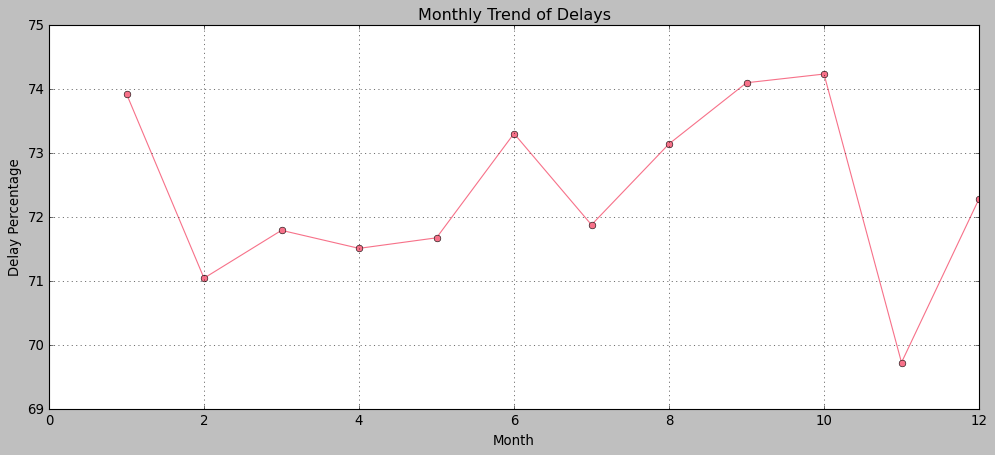

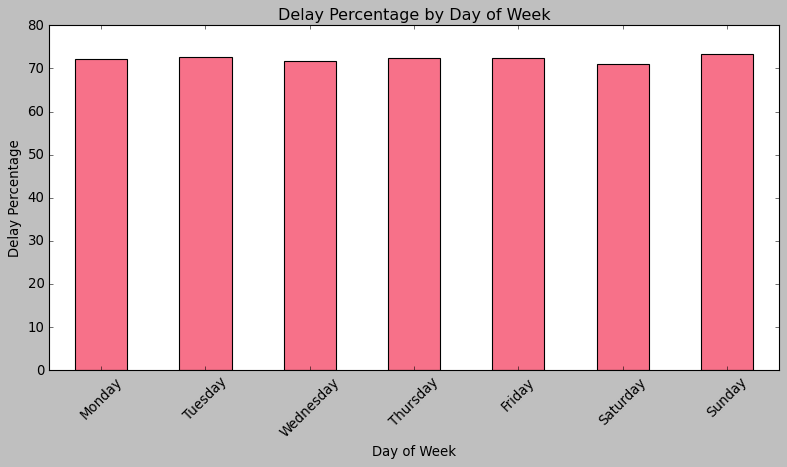


3. Distance Analysis


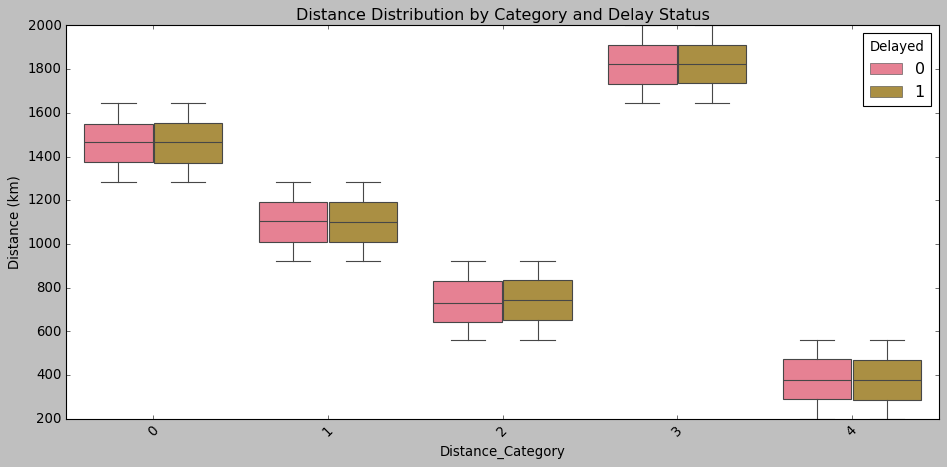

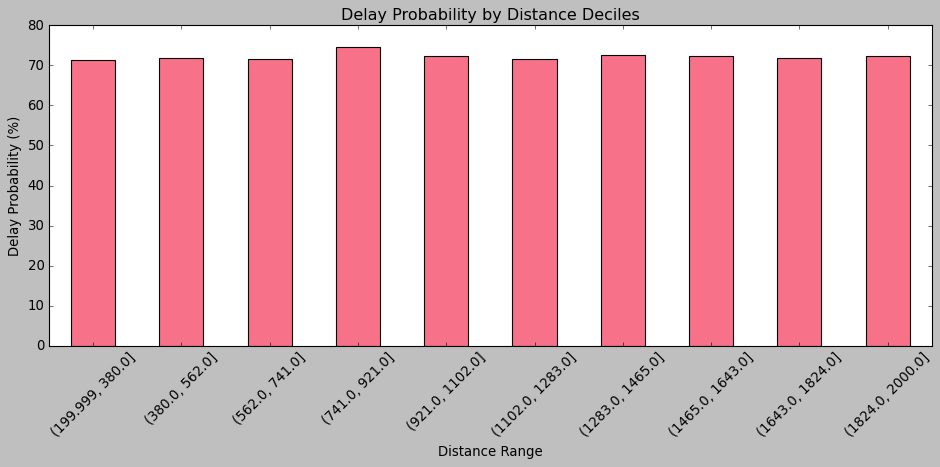


4. Vehicle Type Analysis


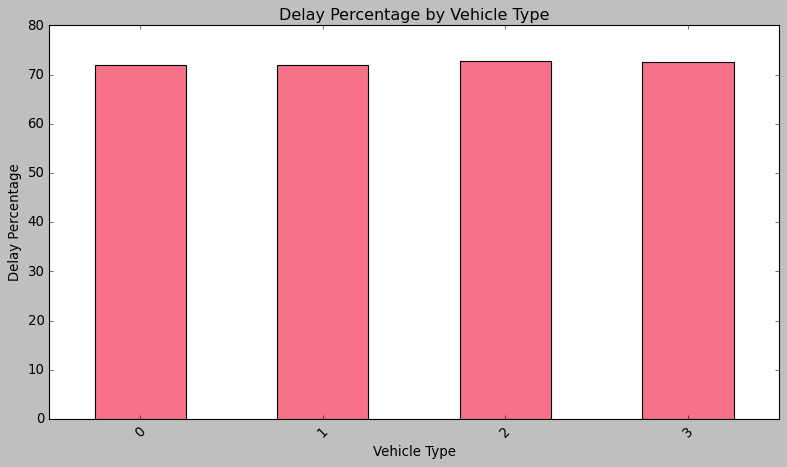

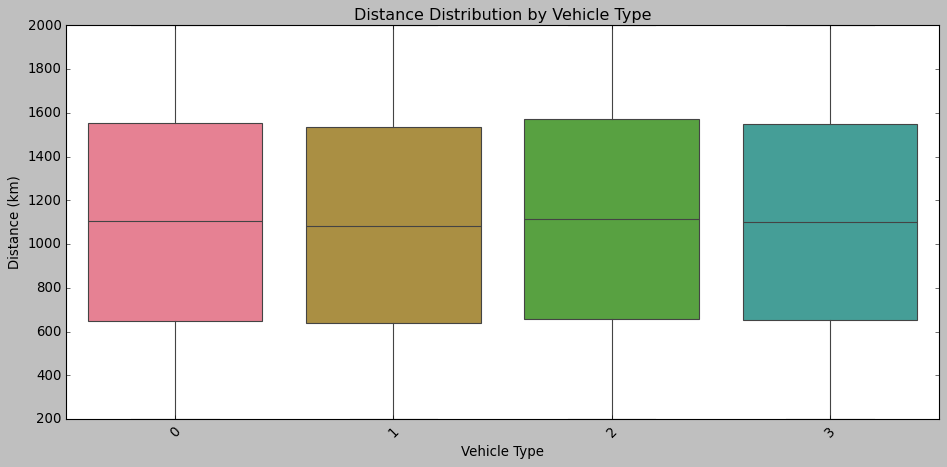


5. Weather and Traffic Impact


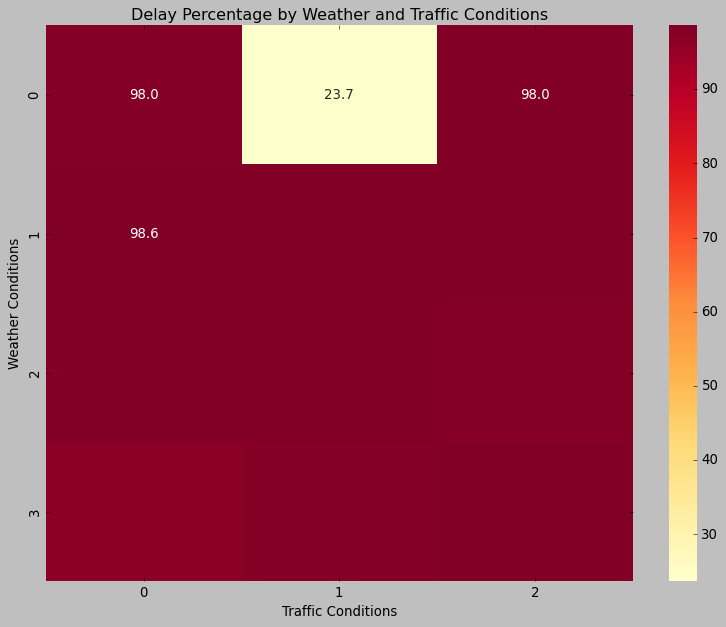


6. Route Analysis


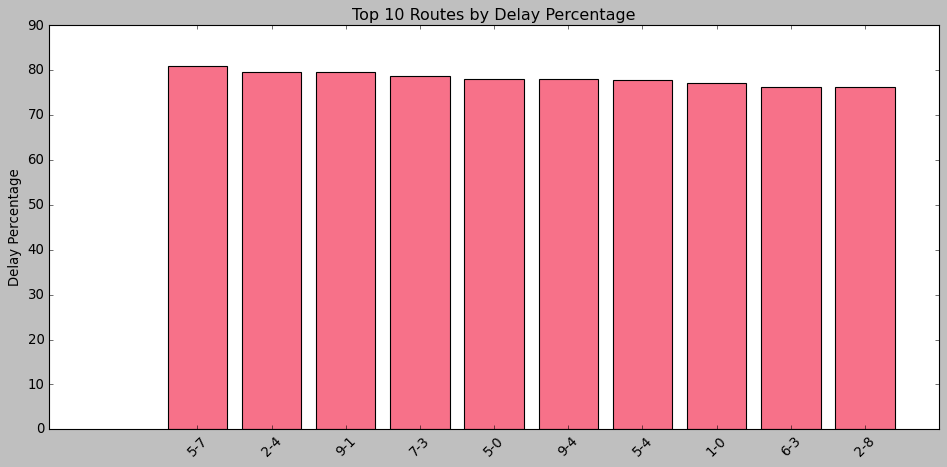


7. Correlation Analysis


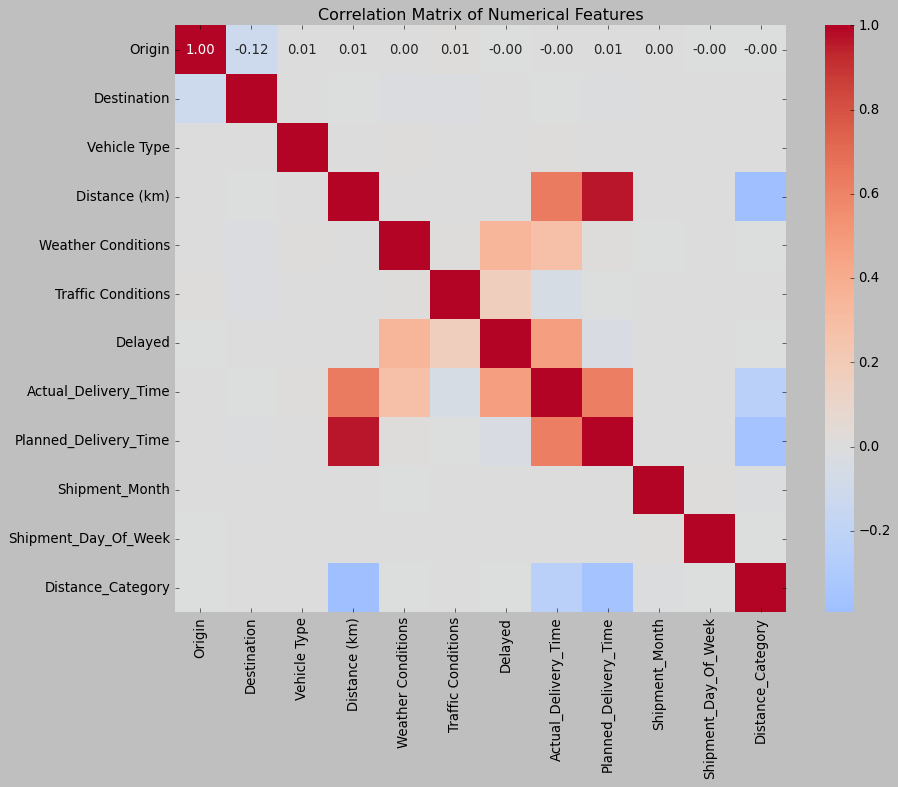


8. Feature Importance Analysis


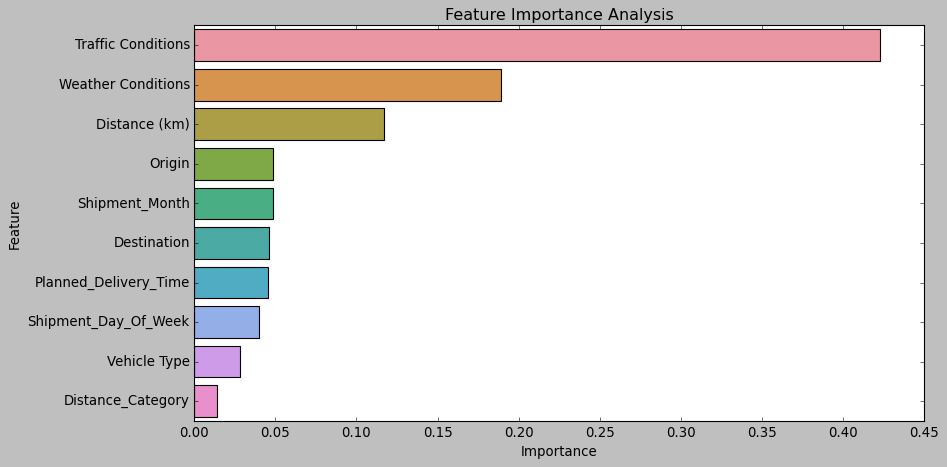


EDA completed successfully!


In [24]:
def main():
    """
    Run all EDA functions and generate insights
    """
    print("Starting Exploratory Data Analysis...")
    
    print("\n1. Basic Statistics")
    print_basic_stats()
    
    print("\n2. Temporal Analysis")
    plot_temporal_patterns()
    
    print("\n3. Distance Analysis")
    analyze_distance()
    
    print("\n4. Vehicle Type Analysis")
    analyze_vehicle_types()
    
    print("\n5. Weather and Traffic Impact")
    analyze_weather_traffic()
    
    print("\n6. Route Analysis")
    analyze_routes()
    
    print("\n7. Correlation Analysis")
    plot_correlations()
    
    print("\n8. Feature Importance Analysis")
    analyze_feature_importance()
    
    print("\nEDA completed successfully!")

if __name__ == "__main__":
    main()